# <a id='toc1_'></a>[Notebook for hyperparameter tuning of the MLP model](#toc0_)

**Table of contents**<a id='toc0_'></a>    
- [Notebook for hyperparameter tuning of the MLP model](#toc1_)    
- [Import libraries](#toc2_)    
- [Import data](#toc3_)    
- [Prepare data for training](#toc4_)    
- [Test hyperparameters](#toc5_)    
  - [Constant scheme](#toc5_1_)    
  - [Pyramid scheme](#toc5_2_)    
    - [Depth and width comparison](#toc5_2_1_)    
    - [Model convergence](#toc5_2_2_)    
  - [Regularization strength](#toc5_3_)    
  - [Pyramid](#toc5_4_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# <a id='toc2_'></a>[Import libraries](#toc0_)

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm
import math
import ast
import gc
import time

from libs.models import *
from libs.functions import *

plt.rcParams.update({'font.size': 12, 'figure.figsize': (10, 4), 'figure.dpi': 300})

# <a id='toc3_'></a>[Import data](#toc0_)

In [2]:
# read data
df = pd.read_csv('data/data.csv')

# <a id='toc4_'></a>[Prepare data for training](#toc0_)

In [3]:
# prepare expanding window splits
periods = {
    '21' : '2020-01-01', # 2021 is the test set
    # '22' : '2021-01-01', # 2022 is the test set
    # '23' : '2022-01-01', # 2023 is the test set
    # '24': '2023-01-01' # 2024 is the test set
}

# identify dummy vs. numeric columns
feature_cols = [col for col in df.columns if col not in ['timestamp', 'ticker', 'target']]
nace_cols = [c for c in feature_cols if c.startswith('NACE_')]
dummy_cols = ['divi','divo'] # sin removed
macro_cols = ['discount', 'tms', 'dp', 'ep', 'svar'] # 'bm_macro'

# nummeric cols = cols not in cat and macro cols
numeric_cols = [c for c in feature_cols if c not in dummy_cols and c not in nace_cols and c not in macro_cols]

df_raw = df.copy(deep=True)
df_raw['timestamp'] = pd.to_datetime(df_raw['timestamp'])

# drop data from 2025
df_raw = df_raw[df_raw['timestamp'] < '2025-01-01']

In [4]:
# create interaction features between numeric and macro features
C = df[numeric_cols].values         # shape = (n_rows, P_c)
X = df[macro_cols].values           # shape = (n_rows, P_x)

# compute all pairwise products with broadcasting:
K = C[:,:,None] * X[:,None,:]

# reshape to (n_rows, P_c * P_x)
Z = K.reshape(len(df), -1)

# build the column names in the same order
xc_names = [
    f"{c}_x_{m}"
    for c in numeric_cols
    for m in macro_cols
]

# wrap back into a DataFrame
df_xc = pd.DataFrame(Z, columns=xc_names, index=df.index)

feature_cols = numeric_cols + xc_names + dummy_cols + nace_cols
numeric_cols = numeric_cols + xc_names
cat_cols = dummy_cols + nace_cols
df_z = df_raw.merge(df_xc, left_index=True, right_index=True)
# drop macro_cols
df_z = df_z.drop(columns=macro_cols)
# sort columns by feature_cols
df_norm = df_z[['timestamp', 'ticker', 'target'] + feature_cols]

y_values = df_norm['target'].values.astype('float32')


In [5]:
# prepare containers
X_train, X_val, X_test = {}, {}, {}
y_train, y_val, y_test = {}, {}, {}
preprocessors = {}
y_scalers = {}

for y, period in periods.items():
    period = pd.to_datetime(period)

    # split masks
    tr_mask = df_norm['timestamp'] < period
    va_mask = (df_norm['timestamp'] >= period) & \
              (df_norm['timestamp'] - pd.DateOffset(years=1) < period)
    te_mask = (df_norm['timestamp'] - pd.DateOffset(years=1) >= period) & \
              (df_norm['timestamp'] - pd.DateOffset(years=2) < period)

    # extract raw feature DataFrames
    X_tr_df = df_norm.loc[tr_mask, feature_cols].copy()
    X_va_df = df_norm.loc[va_mask, feature_cols].copy()
    X_te_df = df_norm.loc[te_mask, feature_cols].copy()
    y_tr    = y_values[tr_mask]
    y_va    = y_values[va_mask]
    y_te    = y_values[te_mask]

    # compute winsorization bounds on train
    lower = X_tr_df[numeric_cols].quantile(0.01)
    upper = X_tr_df[numeric_cols].quantile(0.99)

    # apply clipping to train, val, test
    X_tr_df[numeric_cols] = X_tr_df[numeric_cols].clip(lower=lower, upper=upper, axis=1)
    X_va_df[numeric_cols] = X_va_df[numeric_cols].clip(lower=lower, upper=upper, axis=1)
    X_te_df[numeric_cols] = X_te_df[numeric_cols].clip(lower=lower, upper=upper, axis=1)


    # now fit scaler on numeric only
    preprocessor = ColumnTransformer([
        ('num', StandardScaler(), numeric_cols),
        ('cat', 'passthrough',  cat_cols)
    ])
    preprocessor.fit(X_tr_df)
    preprocessors[y] = preprocessor

    # transform all splits
    X_train[y] = preprocessor.transform(X_tr_df).astype('float32')
    X_val[y]   = preprocessor.transform(X_va_df).astype('float32')
    X_test[y]  = preprocessor.transform(X_te_df).astype('float32')

    # # fit standard scaler on y values
    # y_scaler = StandardScaler()
    # y_scaler.fit(y_tr.reshape(-1, 1))
    # y_scalers[y] = y_scaler
    # y_tr = y_scaler.transform(y_tr.reshape(-1, 1)).flatten()
    # y_va = y_scaler.transform(y_va.reshape(-1, 1)).flatten()
    # y_te = y_scaler.transform(y_te.reshape(-1, 1)).flatten()

    # store targets as before
    y_train[y] = y_tr.reshape(-1, 1)
    y_val[y]   = y_va.reshape(-1, 1)
    y_test[y]  = y_te.reshape(-1, 1)


In [6]:
# moving to metal or CUDA GPU if available
device = torch.device(("cuda" if torch.cuda.is_available() 
                       else "mps" if torch.backends.mps.is_available() 
                       else "cpu"))
print("Using device:", device)

# general hyperparameters
hidden_depth = None 
hidden_width = None 
learning_rate = 1e-4 
activation_fun = nn.ReLU # nn.ReLU, nn.Tanh, nn.Sigmoid, nn.LeakyReLU

# general critereon and regularization parameters
criterion = nn.MSELoss()
lambda_l1 = 1e-5 # baseline l1 regularization
lambda_l2 = 1e-4 # baseline l2 regularization
drop = 0.0

# general parmeters
patience = 25
print_freq = 100
epochs = 250
batch_size = 4096 


Using device: mps


In [7]:
year = '21'
models_21 = {}
n_runs = 5

In [8]:
# model loader fun
def load_model(w, d, run, lambda_l1, lambda_l2, drop, lr):
    m = MLPModel(
        input_dim  = X_train[year].shape[1],
        depth      = d,
        width      = w,
        dropout    = drop,
        activation = activation_fun,
    ).to(device)
    path = (
        f"models/hyperparam_test/mlp_y{year}"
        f"_l1{lambda_l1}_l2{lambda_l2}"
        f"_drop{drop}_lr{lr}"
        f"_w{w}_d{d}_run{run+1}.pth"
    )
    m.load_state_dict(torch.load(path, map_location=device))
    m.eval()
    return m


# <a id='toc5_'></a>[Test hyperparameters](#toc0_)

## <a id='toc5_1_'></a>[Constant scheme](#toc0_)

In [9]:
# # training model with most data on multiple parameters
# l1_space = [lambda_l1]
# l2_space = [lambda_l2]
# dropout_space = [drop]
# learning_rate_space = [learning_rate]
# depth_space = [1, 2, 3, 4, 5, 6, 7]
# width_space = [8, 16, 32, 64, 128]

In [10]:
# # current runtime: 3h 45m
# best_models_size = {}
# history_size = {}

# for lambda_l1 in l1_space:
#     for lambda_l2 in l2_space:
#         for dropout in dropout_space:
#             for learning_rate in learning_rate_space:
#                 for hidden_depth in depth_space:
#                     for hidden_width in width_space:
#                         print(f"""Training model for year '{year}...: 
#                                 lambda_l1       ={lambda_l1:.0e}
#                                 lambda_l2       ={lambda_l2:.0e}
#                                 dropout         ={dropout:.0e}
#                                 learning_rate   ={learning_rate:.0e}
#                                 hidden_depth    ={hidden_depth}
#                                 hidden_width    ={hidden_width}""")
#                         for run in range(n_runs):
#                             print(f"Run {run+1} of {n_runs}")
#                             seed = 42+run   
#                             np.random.seed(seed)
#                             torch.manual_seed(seed)
#                             # Initialize the model
#                             input_dim = X_train[year].shape[1]
#                             name = f'l1{lambda_l1}_l2{lambda_l2}_drop{dropout}_lr{learning_rate}_w{hidden_width}_d{hidden_depth}_run{run+1}'
#                             models_21[name] = MLPModel(input_dim, depth=hidden_depth, width=hidden_width, dropout=dropout, activation=activation_fun).to(device)
#                             optimizer = torch.optim.Adam(models_21[name].parameters(), lr=learning_rate)
#                             train = MLPdataset(X_train[year], y_train[year])
#                             val = MLPdataset(X_val[year], y_val[year])
#                             best_models_size[name], history_size[name] = train_mlp(train,          
#                                                             val,
#                                                             models_21[name],
#                                                             criterion,
#                                                             epochs,
#                                                             patience,
#                                                             print_freq,
#                                                             device,
#                                                             optimizer,
#                                                             lambda_l1=lambda_l1,
#                                                             lambda_l2=lambda_l2,
#                                                             batch_size=batch_size,
#                                                             shuffle_train=True,
#                                                             shuffle_val=False,
#                                                             save_path=f'models/hyperparam_test/mlp_y{year}_l1{lambda_l1}_l2{lambda_l2}_drop{dropout}_lr{learning_rate}_w{hidden_width}_d{hidden_depth}_run{run+1}.pth'
#                                                             )

In [11]:
# flatten_history(history_size, 
#                 save_csv='models/hyperparam_test/history/history_size.csv')
# gc.collect()
# torch.cuda.empty_cache()

## <a id='toc5_2_'></a>[Pyramid scheme](#toc0_)

In [12]:
# # training model with most data on multiple parameters
# l1_space = [lambda_l1]
# l2_space = [lambda_l2]
# dropout_space = [drop]
# learning_rate_space = [learning_rate]
# depth_space = None
# width_space = [[32], 
#                [32, 16], 
#                [32, 16, 8], 
#                [32, 16, 8, 4], 
#                [32, 16, 8, 4, 2]]

In [13]:
# # current runtime: 45m
# best_models_pyramid = {}
# history_pyramid = {}
# for lambda_l1 in l1_space:
#     for lambda_l2 in l2_space:
#         for dropout in dropout_space:
#             for learning_rate in learning_rate_space:
#                 for hidden_width in width_space:
#                     hidden_depth = len(hidden_width)
#                     print(f"""Training model for year '{year}...: 
#                             lambda_l1       ={lambda_l1:.0e}
#                             lambda_l2       ={lambda_l2:.0e}
#                             dropout         ={dropout:.0e}
#                             learning_rate   ={learning_rate:.0e}
#                             hidden_depth    ={hidden_depth}
#                             hidden_width    ={hidden_width}""")
#                     for run in range(n_runs):
#                         print(f"Run {run+1} of {n_runs}")
#                         seed = 42+run
#                         np.random.seed(seed)
#                         torch.manual_seed(seed)
#                         # Initialize the model
#                         input_dim = X_train[year].shape[1]
#                         name = f'l1{lambda_l1}_l2{lambda_l2}_drop{dropout}_lr{learning_rate}_w{hidden_width}_d{hidden_depth}_run{run+1}'
#                         models_21[name] = MLPModel(input_dim, depth=hidden_depth, width=hidden_width, dropout=dropout, activation=activation_fun).to(device)
#                         optimizer = torch.optim.Adam(models_21[name].parameters(), lr=learning_rate)
#                         train = MLPdataset(X_train[year], y_train[year])
#                         val = MLPdataset(X_val[year], y_val[year])
#                         best_models_pyramid[name], history_pyramid[name] = train_mlp(train,          
#                                                         val,
#                                                         models_21[name],
#                                                         criterion,
#                                                         epochs,
#                                                         patience,
#                                                         print_freq,
#                                                         device,
#                                                         optimizer,
#                                                         lambda_l1=lambda_l1,
#                                                         lambda_l2=lambda_l2,
#                                                         batch_size=batch_size,
#                                                         shuffle_train=True,
#                                                         shuffle_val=False,
#                                                         save_path=f'models/hyperparam_test/mlp_y{year}_l1{lambda_l1}_l2{lambda_l2}_drop{dropout}_lr{learning_rate}_w{hidden_width}_d{hidden_depth}_run{run+1}.pth'
#                                                         )

In [14]:
# flatten_history(history_pyramid, 
#                 save_csv='models/hyperparam_test/history/history_pyramid.csv')
# gc.collect()
# torch.cuda.empty_cache()

### <a id='toc5_2_1_'></a>[Depth and width comparison](#toc0_)

In [15]:
# constant-width grid
const_widths = [8, 16, 32, 64, 128]
const_depths = [1, 2, 3, 4, 5, 6, 7]

# pyramid sequences (each column of the right heatmap)
pyr_seqs = [
    [32],
    [32,16],
    [32,16,8],
    [32,16,8,4],
    [32,16,8,4,2],
]
Wc = len(const_widths)
Dc = len(const_depths)
Wp = len(pyr_seqs)

# DataLoader
val_ds     = MLPdataset(X_val[year], y_val[year])
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False)

# constant-width loss matrix
loss_const = np.zeros((Dc, Wc))
for di, d in enumerate(const_depths):
    for wj, w in enumerate(const_widths):
        run_losses = []
        for run in range(n_runs):
            m = load_model(w, d, run, lambda_l1, lambda_l2, drop, learning_rate)
            with torch.no_grad():
                batch = [criterion(m(x.to(device)), y.to(device)).item()
                         for x,y in val_loader]
            run_losses.append(np.mean(batch))
        loss_const[di, wj] = np.mean(run_losses)

# pyramid loss matrix
loss_pyr = np.full((Wp, Wp), np.nan)
for sj, seq in enumerate(pyr_seqs):
    depth = len(seq)
    run_losses = []
    for run in range(n_runs):
        # we “flatten” seq into width param for loader
        m = load_model(seq, depth, run, lambda_l1, lambda_l2, drop, learning_rate)
        with torch.no_grad():
            batch = [criterion(m(x.to(device)), y.to(device)).item()
                     for x,y in val_loader]
        run_losses.append(np.mean(batch))
    loss_pyr[depth-1, sj] = np.mean(run_losses)

# plot
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(12,5),
                               gridspec_kw={'width_ratios':[4,1]})

# color‐scale
all_vals = loss_const.ravel()
vmin    = all_vals.min()-0.0005
vmax    = all_vals.max()
vcenter = vmin + 0.5*(vmax - vmin)
norm    = TwoSlopeNorm(vmin=vmin, vcenter=vcenter, vmax=vmax)
cmap    = 'viridis'

# left: constant‐width heatmap
im0 = ax0.imshow(loss_const, aspect='auto', cmap=cmap, norm=norm)
im0 = ax0.imshow(loss_const, aspect='auto', cmap=cmap, norm=norm)
ax0.set_xticks(range(Wc))
ax0.set_xticklabels(const_widths)
ax0.set_yticks(range(Dc))
ax0.set_yticklabels(const_depths)
ax0.set_xlabel('Hidden Width')
ax0.set_ylabel('Hidden Depth')
ax0.set_title(f'Constant Width')

# right: collapsed‐x pyramid heatmap
diag_pyr = np.diag(loss_pyr)
diag_mat = diag_pyr[:, np.newaxis]

im1 = ax1.imshow(diag_mat, aspect='auto', cmap=cmap, norm=norm)
ax1.set_xticks([0])
ax1.set_xticklabels(['Geometric\npyramid'])
ax1.set_yticks(np.arange(Wp))
ax1.set_yticklabels(np.arange(1, Wp+1))
ax1.set_ylabel('Hidden Depth')
ax1.set_title('Pyramid Scheme')

# shared colorbar
cbar = fig.colorbar(im0, ax=[ax0,ax1], shrink=0.9, pad=0.02)
cbar.set_label('Average Validation Loss (MSE)')

plt.savefig('figs/width_depth.png', dpi=300, bbox_inches='tight')
# plt.show()
plt.close()

In [16]:
# pre‐compute global vmin/vmax across all runs so color‐scale is consistent
all_vals = []
for run in range(n_runs):
    # constant‐width for this run
    tmp = []
    for d in const_depths:
        for w in const_widths:
            m = load_model(w, d, run, lambda_l1, lambda_l2, drop, learning_rate)
            with torch.no_grad():
                batch = [criterion(m(x.to(device)), y.to(device)).item()
                         for x,y in val_loader]
            tmp.append(np.mean(batch))
    all_vals.extend(tmp)

    # pyramid diag for this run
    diag = []
    for seq in pyr_seqs:
        depth = len(seq)
        m = load_model(seq, depth, run, lambda_l1, lambda_l2, drop, learning_rate)
        with torch.no_grad():
            batch = [criterion(m(x.to(device)), y.to(device)).item()
                     for x,y in val_loader]
        diag.append(np.mean(batch))
    all_vals.extend(diag)

runs = list(range(n_runs))
# split into pages of 4 runs each
pages = [runs[i:i+4] for i in range(0, len(runs), 4)]

for p, page_runs in enumerate(pages, start=1):
    nrows = len(page_runs)
    fig, axes = plt.subplots(
        nrows, 2,
        figsize=(10, 3*nrows),
        gridspec_kw={'width_ratios': [4, 1]},
        constrained_layout=False  # turn off for manual colorbar placement
    )

    # if only one row, wrap axes
    if nrows == 1:
        axes = np.expand_dims(axes, 0)

    for i, run in enumerate(page_runs):
        ax0, ax1 = axes[i]

        # ---- left: constant-width heatmap for this run ----
        loss_const = np.zeros((Dc, Wc))
        for di, d in enumerate(const_depths):
            for wj, w in enumerate(const_widths):
                m = load_model(w, d, run, lambda_l1, lambda_l2, drop, learning_rate)
                with torch.no_grad():
                    batch = [criterion(m(x.to(device)), y.to(device)).item()
                             for x,y in val_loader]
                loss_const[di, wj] = np.mean(batch)

        im0 = ax0.imshow(loss_const, aspect='auto', cmap=cmap, norm=norm)
        if i == 0:
            ax0.set_title('Constant Width')
        ax0.set_ylabel(f'Run {run+1}\nHidden Depth')
        ax0.set_xticks(range(Wc))
        ax0.set_xticklabels(const_widths)
        ax0.set_yticks(range(Dc))
        ax0.set_yticklabels(const_depths)
        if i == nrows - 1:
            ax0.set_xlabel('Hidden Width')
        else:
            ax0.set_xlabel('')
            ax0.tick_params(labelbottom=False)

        # ---- right: collapsed pyramid for this run ----
        diag = []
        for seq in pyr_seqs:
            depth = len(seq)
            m = load_model(seq, depth, run, lambda_l1, lambda_l2, drop, learning_rate)
            with torch.no_grad():
                batch = [criterion(m(x.to(device)), y.to(device)).item()
                         for x,y in val_loader]
            diag.append(np.mean(batch))
        diag_mat = np.array(diag)[:, None]

        im1 = ax1.imshow(diag_mat, aspect='auto', cmap=cmap, norm=norm)
        if i == 0:
            ax1.set_title('Pyramid Scheme')
        ax1.set_xticks([0])
        # only label the bottom subplot
        if i == nrows - 1:
            ax1.set_xticklabels(['Geometric\npyramid'])
        else:
            ax1.set_xticklabels([])
        ax1.set_yticks(range(Wp))
        ax1.set_yticklabels(range(1, Wp+1))
        ax1.set_ylabel('Hidden Depth')

    # shared colorbar on the right of this page
    cax = fig.add_axes([0.92,  # 92% from left
                        0.11,  # 10% from bottom
                        0.02,  # 2% figure‐width
                        0.77   # 80% figure‐height
                       ])
    cbar = fig.colorbar(im0, cax=cax)
    cbar.set_label('Validation Loss (MSE)')

    fig.savefig(f'figs/width_depth_page{p}.png', dpi=300, bbox_inches='tight')
    # plt.show()
    plt.close()


### <a id='toc5_2_2_'></a>[Model convergence](#toc0_)

In [17]:
# CSVs
df_size = pd.read_csv('models/hyperparam_test/history/history_size.csv')
df_pyr  = pd.read_csv('models/hyperparam_test/history/history_pyramid.csv')

# extract name
df_size['widths'] = df_size['widths'].apply(ast.literal_eval)
df_pyr ['widths'] = df_pyr ['widths'].apply(ast.literal_eval)

df_size['width'] = df_size['widths'].apply(lambda w: w[0])
df_pyr ['width'] = df_pyr ['widths'].apply(lambda w: w[0])

df_size['name'] = df_size['width'].apply(
    lambda w: f"Constant width = {w}"
)

width_to_str = (
    df_pyr
    .groupby('width')['widths_str']
    .agg(lambda ss: max(ss, key=len))
    .to_dict()
)
df_pyr['name'] = df_pyr['width'].map(
    lambda w: f"Pyramid width = {width_to_str[w]}"
)

# combine
df = pd.concat([df_size, df_pyr], ignore_index=True)

# sort by width
panel_df = (
    df[['name','width']]            # pick only the two columns we care about
      .drop_duplicates()            # one row per unique panel
      .assign(is_pyr=lambda x: x['name'].str.startswith('Pyramid'))
      .sort_values(['is_pyr','width'])  # constants (is_pyr=False) first, then pyramids; each by ascending width
)

plot_names = panel_df['name'].tolist()
n = len(plot_names)
n_cols = min(3, n)
n_rows = math.ceil(n / n_cols)

fig, axes = plt.subplots(n_rows, n_cols,
                         figsize=(4*n_cols, 4*n_rows),
                         sharey=True)
axes = axes.flatten()

# build a unified color map over depths
depths = sorted(df['depth'].unique())
cmap   = plt.get_cmap('viridis')
colors = {d: cmap(i/(len(depths)-1)) for i, d in enumerate(depths)}

for idx, name in enumerate(plot_names):
    ax = axes[idx]
    sub_df = df[df['name'] == name]
    for d in depths:
        sd = sub_df[sub_df['depth'] == d]
        for run in sd['run'].unique():
            run_df = sd[sd['run'] == run].sort_values('epoch')
            ax.plot(
                run_df['epoch'],
                run_df['val_loss'],
                color=colors[d],
                alpha=0.5,
                linewidth=2,
                label=(f"d={d}" if run == sd['run'].min() else None)
            )

    ax.set_title(name)
    ax.set_yscale('log')
    ax.set_ylim(1.9e-2, 4.1e-2)
    ax.set_xlim(0, 250)
    ax.set_xticks(np.linspace(0, 250, 6, dtype=int))

    # only bottom row: x-label
    if idx // n_cols == n_rows - 1:
        ax.set_xlabel("Epoch", fontsize=12)
    else:
        ax.set_xticklabels([])

    # only leftmost column: y-label
    if idx % n_cols == 0:
        ax.set_ylabel("Validation Loss", fontsize=12)

# remove any unused axes
for j in range(len(plot_names), len(axes)):
    fig.delaxes(axes[j])

# global legend on right
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels,
           title="Hidden Depth",
           loc='center left',
           bbox_to_anchor=(1, 0.5),
           fontsize=12)

plt.tight_layout() 
plt.savefig('figs/val_loss_history.png', dpi=300, bbox_inches='tight')
# plt.show()
plt.close()


## <a id='toc5_3_'></a>[Regularization strength](#toc0_)

In [18]:
# # training model with most data on multiple parameters
# l1_space = [0.0, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2]
# l2_space = [0.0, 1e-5, 1e-4, 1e-3, 1e-2]
# dropout_space = [0.0, 0.1, 0.2, 0.3] 
# learning_rate_space = [learning_rate] 
# depth_space = [4] 
# width_space = [16]

In [19]:
# # current runtime: 15h
# best_models_reg = {}
# history_reg = {}
# for lambda_l1 in l1_space:
#     for lambda_l2 in l2_space:
#         for dropout in dropout_space:
#             for learning_rate in learning_rate_space:
#                 for hidden_depth in depth_space:
#                     for hidden_width in width_space:
#                         print(f"""Training model for year '{year}...: 
#                                 lambda_l1       ={lambda_l1:.0e}
#                                 lambda_l2       ={lambda_l2:.0e}
#                                 dropout         ={dropout:.0e}
#                                 learning_rate   ={learning_rate:.0e}
#                                 hidden_depth    ={hidden_depth}
#                                 hidden_width    ={hidden_width}""")
#                         for run in range(n_runs):
#                             print(f"Run {run+1} of {n_runs}")
#                             seed = 42+run
#                             np.random.seed(seed)
#                             torch.manual_seed(seed)
#                             # Initialize the model
#                             input_dim = X_train[year].shape[1]
#                             name = f'l1{lambda_l1}_l2{lambda_l2}_drop{dropout}_lr{learning_rate}_w{hidden_width}_d{hidden_depth}_run{run+1}'
#                             models_21[name] = MLPModel(input_dim, depth=hidden_depth, width=hidden_width, dropout=dropout, activation=activation_fun).to(device)
#                             optimizer = torch.optim.Adam(models_21[name].parameters(), lr=learning_rate)
#                             train = MLPdataset(X_train[year], y_train[year])
#                             val = MLPdataset(X_val[year], y_val[year])
#                             best_models_reg[name], history_reg[name] = train_mlp(train,          
#                                                             val,
#                                                             models_21[name],
#                                                             criterion,
#                                                             epochs,
#                                                             patience,
#                                                             print_freq,
#                                                             device,
#                                                             optimizer,
#                                                             lambda_l1=lambda_l1,
#                                                             lambda_l2=lambda_l2,
#                                                             batch_size=batch_size,
#                                                             shuffle_train=True,
#                                                             shuffle_val=False,
#                                                             save_path=f'models/hyperparam_test/mlp_y{year}_l1{lambda_l1}_l2{lambda_l2}_drop{dropout}_lr{learning_rate}_w{hidden_width}_d{hidden_depth}_run{run+1}.pth'
#                                                             )

In [20]:
# flatten_history(history_reg, 
#                 save_csv='models/hyperparam_test/history/history_reg.csv')
# gc.collect()
# torch.cuda.empty_cache()

In [21]:
# training model with most data on multiple parameters
l1_space = [0.0, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2]
l2_space = [0.0, 1e-5, 1e-4, 1e-3, 1e-2]
dropout_space = [0.0, 0.1, 0.2, 0.3] 
learning_rate_space = [learning_rate] 
depth_space = [4] 
width_space = [16]

In [22]:
# DataLoader
val_ds     = MLPdataset(X_val[year], y_val[year])
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False)

# build (n_drop, n_l1, n_l2) mean-loss array
n_l1   = len(l1_space)
n_l2   = len(l2_space)
n_drop = len(dropout_space)

losses = np.zeros((n_drop, n_l1, n_l2), dtype=float)

for di, drop in enumerate(dropout_space):
    for i, l1 in enumerate(l1_space):
        for j, l2 in enumerate(l2_space):
            run_losses = []
            # for each seed, load & eval
            for run in range(n_runs):
                # since depth_space & width_space each have one entry, 
                # we can just index 0 here — but this will generalize
                tmp_losses = []
                for d in depth_space:
                    for w in width_space:
                        m = load_model(w, d, run, l1, l2, drop, learning_rate, )
                        with torch.no_grad():
                            batch = [criterion(m(x.to(device)), y.to(device)).item()
                                     for x,y in val_loader]
                        tmp_losses.append(np.mean(batch))
                run_losses.append(np.mean(tmp_losses))
            # now average over runs
            losses[di, i, j] = np.mean(run_losses)


# global color‐scale
vmin    = losses.min()
vmax    = losses.max()
vcenter = vmin + 0.5*(vmax - vmin)
norm    = TwoSlopeNorm(vmin=vmin, vcenter=vcenter, vmax=vmax)
cmap    = 'viridis'

# layout: up to 2 columns
ncols = min(2, n_drop)
nrows = math.ceil(n_drop / ncols)

fig, axes = plt.subplots(nrows, ncols,
                         figsize=(5*ncols, 4*nrows),
                         squeeze=False)
axes_flat = axes.flatten()

for idx, drop in enumerate(dropout_space):
    ax = axes_flat[idx]
    im = ax.imshow(
        losses[idx],
        aspect='auto',
        cmap=cmap,
        norm=norm,
        origin='lower',
    )

    # y = l1, x = l2
    ax.set_yticks(np.arange(n_l1))
    ax.set_yticklabels(l1_space)
    ax.set_xticks(np.arange(n_l2))
    ax.set_xticklabels(l2_space)

    # only bottom row shows x‐labels
    if idx < (nrows-1)*ncols:
        ax.tick_params(labelbottom=False)
    else:
        ax.set_xlabel(r'$\ell_2$')

    # only first‐column shows y‐labels
    if idx % ncols != 0:
        ax.tick_params(labelleft=False)
    else:
        ax.set_ylabel(r'$\ell_1$')

    ax.set_title(f"dropout = {drop:.2f}")

# clear unused
for ax in axes_flat[n_drop:]:
    fig.delaxes(ax)

# colorbar at the right edge
fig.subplots_adjust(right=0.88)
cax = fig.add_axes([0.90, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
cbar = fig.colorbar(im, cax=cax)
cbar.set_label('Average Validation Loss (MSE)')

plt.savefig('figs/l1_l2_dropout_loss.png', dpi=300, bbox_inches='tight')
# plt.show()
plt.close()

## <a id='toc5_4_'></a>[Pyramid](#toc0_)

In [23]:
# training model with most data on multiple parameters
l1_space = [0.0, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2]
l2_space = [0.0, 1e-5, 1e-4, 1e-3, 1e-2]
dropout_space = [0.0, 0.1, 0.2, 0.3] 
learning_rate_space = [learning_rate]
depth_space = None
width_space = [[32, 16, 8]]

best_models_reg_pyramid = {}
history_reg_pyramid = {}

In [24]:
# # current runtime: 15h
# for lambda_l1 in l1_space:
#     for lambda_l2 in l2_space:
#         for dropout in dropout_space:
#             for learning_rate in learning_rate_space:
#                 for hidden_width in width_space:
#                     hidden_depth = len(hidden_width)
#                     print(f"""Training model for year '{year}...: 
#                             lambda_l1       ={lambda_l1:.0e}
#                             lambda_l2       ={lambda_l2:.0e}
#                             dropout         ={dropout:.0e}
#                             learning_rate   ={learning_rate:.0e}
#                             hidden_depth    ={hidden_depth}
#                             hidden_width    ={hidden_width}""")
#                     for run in range(n_runs):
#                         print(f"Run {run+1} of {n_runs}")
#                         seed = 42+run
#                         np.random.seed(seed)
#                         torch.manual_seed(seed)
#                         # Initialize the model
#                         input_dim = X_train[year].shape[1]
#                         name = f'l1{lambda_l1}_l2{lambda_l2}_drop{dropout}_lr{learning_rate}_w{hidden_width}_d{hidden_depth}_run{run+1}'
#                         models_21[name] = MLPModel(input_dim, depth=hidden_depth, width=hidden_width, dropout=dropout, activation=activation_fun).to(device)
#                         optimizer = torch.optim.Adam(models_21[name].parameters(), lr=learning_rate)
#                         train = MLPdataset(X_train[year], y_train[year])
#                         val = MLPdataset(X_val[year], y_val[year])
#                         best_models_reg_pyramid[name], history_reg_pyramid[name] = train_mlp(train,          
#                                                         val,
#                                                         models_21[name],
#                                                         criterion,
#                                                         epochs,
#                                                         patience,
#                                                         print_freq,
#                                                         device,
#                                                         optimizer,
#                                                         lambda_l1=lambda_l1,
#                                                         lambda_l2=lambda_l2,
#                                                         batch_size=batch_size,
#                                                         shuffle_train=True,
#                                                         shuffle_val=False,
#                                                         save_path=f'models/hyperparam_test/mlp_y{year}_l1{lambda_l1}_l2{lambda_l2}_drop{dropout}_lr{learning_rate}_w{hidden_width}_d{hidden_depth}_run{run+1}.pth'
#                                                         )

In [25]:
# DataLoader
val_ds     = MLPdataset(X_val[year], y_val[year])
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False)

# build (n_drop, n_l1, n_l2) mean-loss array
n_l1   = len(l1_space)
n_l2   = len(l2_space)
n_drop = len(dropout_space)

losses = np.zeros((n_drop, n_l1, n_l2), dtype=float)

for di, drop in enumerate(dropout_space):
    for i, l1 in enumerate(l1_space):
        for j, l2 in enumerate(l2_space):
            run_losses = []
            # for each seed, load & eval
            for run in range(n_runs):
                # since depth_space & width_space each have one entry, 
                # we can just index 0 here — but this will generalize
                tmp_losses = []
                for w in width_space:
                    d = len(w)  # since w is a list, we can use its length
                    m = load_model(w, d, run, l1, l2, drop, learning_rate, )
                    with torch.no_grad():
                        batch = [criterion(m(x.to(device)), y.to(device)).item()
                                    for x,y in val_loader]
                    tmp_losses.append(np.mean(batch))
                run_losses.append(np.mean(tmp_losses))
            # now average over runs
            losses[di, i, j] = np.mean(run_losses)


# global color‐scale
vmin    = losses.min()
vmax    = losses.max()
vcenter = vmin + 0.5*(vmax - vmin)
norm    = TwoSlopeNorm(vmin=vmin, vcenter=vcenter, vmax=vmax)
cmap    = 'viridis'

# layout: up to 2 columns
ncols = min(2, n_drop)
nrows = math.ceil(n_drop / ncols)

fig, axes = plt.subplots(nrows, ncols,
                         figsize=(5*ncols, 4*nrows),
                         squeeze=False)
axes_flat = axes.flatten()

for idx, drop in enumerate(dropout_space):
    ax = axes_flat[idx]
    im = ax.imshow(
        losses[idx],
        aspect='auto',
        cmap=cmap,
        norm=norm,
        origin='lower',
    )

    # y = l1, x = l2
    ax.set_yticks(np.arange(n_l1))
    ax.set_yticklabels(l1_space)
    ax.set_xticks(np.arange(n_l2))
    ax.set_xticklabels(l2_space)

    # only bottom row shows x‐labels
    if idx < (nrows-1)*ncols:
        ax.tick_params(labelbottom=False)
    else:
        ax.set_xlabel(r'$\ell_2$')

    # only first‐column shows y‐labels
    if idx % ncols != 0:
        ax.tick_params(labelleft=False)
    else:
        ax.set_ylabel(r'$\ell_1$')

    ax.set_title(f"dropout = {drop:.2f}")

# clear unused
for ax in axes_flat[n_drop:]:
    fig.delaxes(ax)

# colorbar at the right edge
fig.subplots_adjust(right=0.88)
cax = fig.add_axes([0.90, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
cbar = fig.colorbar(im, cax=cax)
cbar.set_label('Average Validation Loss (MSE)')

plt.savefig('figs/l1_l2_dropout_loss_pyramid.png', dpi=300, bbox_inches='tight')
# plt.show()
plt.close()

# Test of activation functions

In [26]:
# general hyperparameters
hidden_depth = 4 
hidden_width = 16 
learning_rate = 1e-4 

# general critereon and regularization parameters
criterion = nn.MSELoss()
lambda_l1 = 1e-5 # baseline l1 regularization
lambda_l2 = 1e-4 # baseline l2 regularization
dropout = 0.0

activation_fun_space = {'ReLU':nn.ReLU, 'LeakyReLU':nn.LeakyReLU, 'Tanh':nn.Tanh, 'Sigmoid':nn.Sigmoid}

In [27]:
best_models_activ = {}
history_activ = {}
run_time = {}
for activ_name, activation_fun in activation_fun_space.items():
    start_time = time.time()
    print(f"""Training model for year '{year}...: 
            activation      ={activ_name}
            lambda_l1       ={lambda_l1:.0e}
            lambda_l2       ={lambda_l2:.0e}
            dropout         ={dropout:.0e}
            learning_rate   ={learning_rate:.0e}
            hidden_depth    ={hidden_depth}
            hidden_width    ={hidden_width}""")
    for run in range(n_runs):
        start_time_run = time.time()
        print(f"Run {run+1} of {n_runs}")
        seed = 42+run
        np.random.seed(seed)
        torch.manual_seed(seed)
        # Initialize the model
        input_dim = X_train[year].shape[1]
        name = f'l1{lambda_l1}_l2{lambda_l2}_drop{dropout}_lr{learning_rate}_w{hidden_width}_d{hidden_depth}_run{run+1}_activ{activ_name}'
        models_21[name] = MLPModel(input_dim, depth=hidden_depth, width=hidden_width, dropout=dropout, activation=activation_fun).to(device)
        optimizer = torch.optim.Adam(models_21[name].parameters(), lr=learning_rate)
        train = MLPdataset(X_train[year], y_train[year])
        val = MLPdataset(X_val[year], y_val[year])
        best_models_activ[name], history_activ[name] = train_mlp(train,          
                                        val,
                                        models_21[name],
                                        criterion,
                                        epochs,
                                        patience,
                                        print_freq,
                                        device,
                                        optimizer,
                                        lambda_l1=lambda_l1,
                                        lambda_l2=lambda_l2,
                                        batch_size=batch_size,
                                        shuffle_train=True,
                                        shuffle_val=False,
                                        save_path=f'models/hyperparam_test/mlp_y{year}_l1{lambda_l1}_l2{lambda_l2}_drop{dropout}_lr{learning_rate}_w{hidden_width}_d{hidden_depth}_run{run+1}_activ{activ_name}.pth'
                                        )
        end_time_run = time.time()
        run_time[f'run_{run+1}'] = end_time_run - start_time_run
    end_time = time.time()
    print(f"Training with activation nn.{activ_name} took {end_time - start_time:.2f} seconds.")
    print(f'Average time per run: {np.mean(list(run_time.values())):.2f} seconds.')

Training model for year '21...: 
            activation      =ReLU
            lambda_l1       =1e-05
            lambda_l2       =1e-04
            dropout         =0e+00
            learning_rate   =1e-04
            hidden_depth    =4
            hidden_width    =16
Run 1 of 5
Early stopping at epoch 58
Best val loss: 1.96935E-02
Model saved to models/hyperparam_test/mlp_y21_l11e-05_l20.0001_drop0.0_lr0.0001_w16_d4_run1_activReLU.pth
Run 2 of 5
Epoch 100/250  - Train Loss: 2.64055E-02  - Val Loss: 1.94237E-02
Early stopping at epoch 176
Best val loss: 1.92907E-02
Model saved to models/hyperparam_test/mlp_y21_l11e-05_l20.0001_drop0.0_lr0.0001_w16_d4_run2_activReLU.pth
Run 3 of 5
Early stopping at epoch 47
Best val loss: 1.95795E-02
Model saved to models/hyperparam_test/mlp_y21_l11e-05_l20.0001_drop0.0_lr0.0001_w16_d4_run3_activReLU.pth
Run 4 of 5
Early stopping at epoch 68
Best val loss: 1.94935E-02
Model saved to models/hyperparam_test/mlp_y21_l11e-05_l20.0001_drop0.0_lr0.0001_w16_d

In [29]:
flatten_history_activ(history_activ, 
                save_csv='models/hyperparam_test/history/history_activ.csv')
# gc.collect()
# torch.cuda.empty_cache()

,l1,l2,dropout,lr,widths,widths_str,depth,run,epoch,train_loss,val_loss,activ_name
0,0.00001,0.0001,0.0,0.0001,[16],16,4,1,1,0.042531,0.030154,ReLU
1,0.00001,0.0001,0.0,0.0001,[16],16,4,1,2,0.040496,0.028538,ReLU
2,0.00001,0.0001,0.0,0.0001,[16],16,4,1,3,0.038632,0.026985,ReLU
3,0.00001,0.0001,0.0,0.0001,[16],16,4,1,4,0.036939,0.025466,ReLU
4,0.00001,0.0001,0.0,0.0001,[16],16,4,1,5,0.035449,0.024006,ReLU
...,...,...,...,...,...,...,...,...,...,...,...,...
2167,0.00001,0.0001,0.0,0.0001,[16],16,4,5,83,0.027579,0.019845,Sigmoid
2168,0.00001,0.0001,0.0,0.0001,[16],16,4,5,84,0.027569,0.019847,Sigmoid
2169,0.00001,0.0001,0.0,0.0001,[16],16,4,5,85,0.027560,0.019848,Sigmoid
2170,0.00001,0.0001,0.0,0.0001,[16],16,4,5,86,0.027550,0.019845,Sigmoid


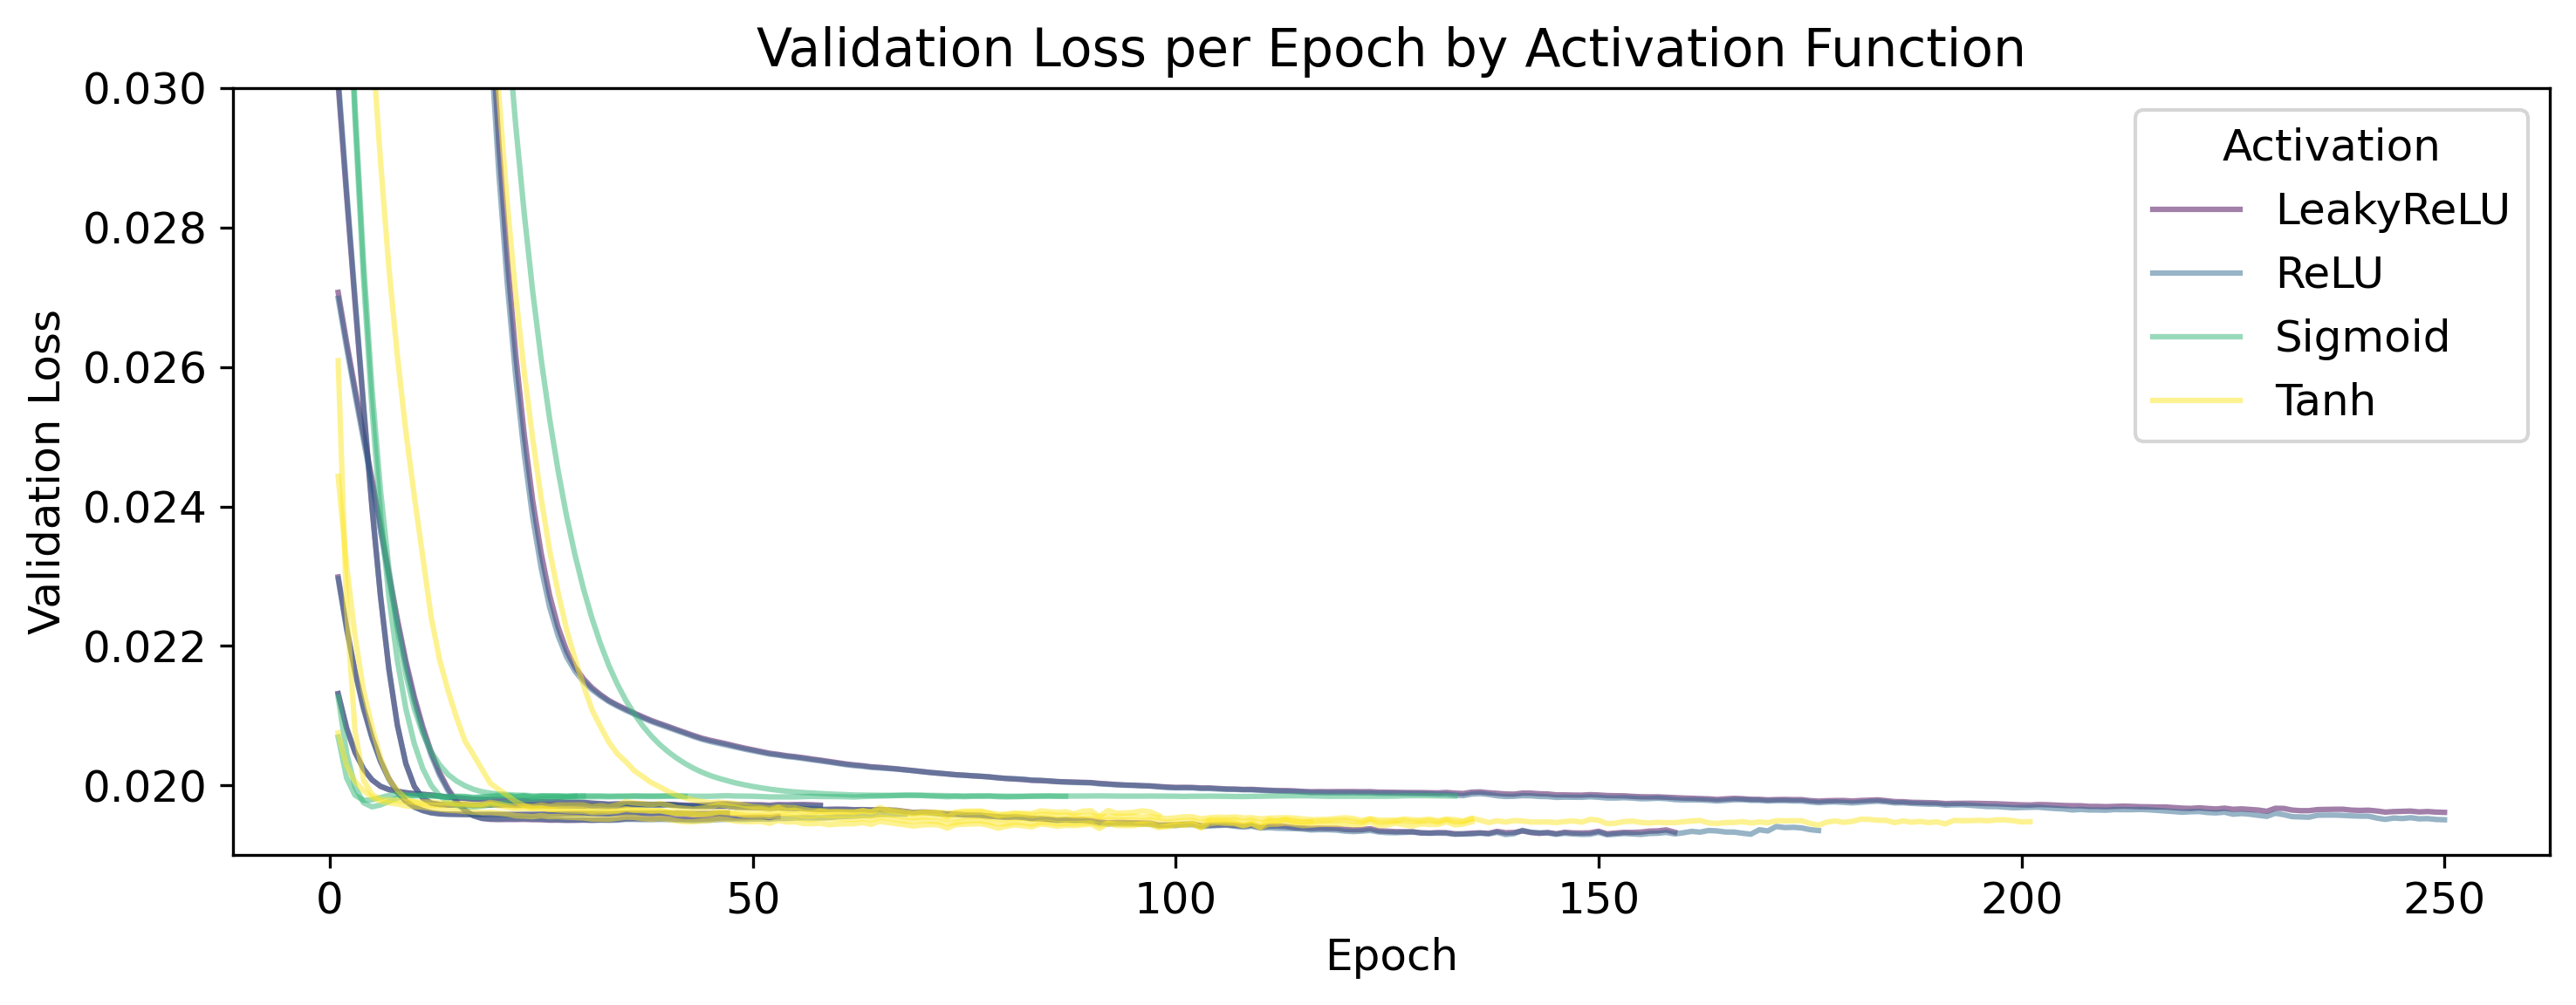

In [ ]:
df_activ = pd.read_csv('models/hyperparam_test/history/history_activ.csv')
# df_activ = df_activ[df_activ['activ_name'] == 'ReLU']

# determine a distinct color for each activation from the viridis colormap
activations = sorted(df_activ['activ_name'].unique())
n_acts = len(activations)
cmap = plt.get_cmap('viridis', n_acts)
color_map = {act: cmap(i) for i, act in enumerate(activations)}
seen = set()

plt.figure()
# plot every run, but only label each activation once
for (activ_name, run_id), grp in df_activ.groupby(['activ_name', 'run']):
    label = activ_name if activ_name not in seen else '_nolegend_'
    seen.add(activ_name)
    plt.plot(
        grp['epoch'],
        grp['val_loss'],
        color=color_map[activ_name],
        alpha=0.5,
        label=label
    )

plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.title('Validation Loss per Epoch by Activation Function')
plt.ylim(0.019, 0.03)
plt.legend(title='Activation')
plt.tight_layout()
plt.savefig('figs/activation_fun_history.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()